### Test metrics on official chexpert validation set (test set for this project)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score, roc_curve

# Custom objects required for loading CheXpert multi-label classification models
import sys 
sys.path.append('..')
from loss import (
    set_binary_crossentropy_weighted_loss
)

2021-11-28 20:36:56.928177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### 1- Loading test set

In [2]:
test_df = pd.read_csv(
    filepath_or_buffer="../labels/train_validation_split_data/validation_u-zeroes.csv",
    dtype={  # Setting labels to type np.float32 was necessary for conversion to tf.Tensor object
        "Path": str,
        "Atelectasis": np.float32,
        "Cardiomegaly": np.float32,
        "Consolidation": np.float32,
        "Edema": np.float32,
        "Pleural Effusion": np.float32,
        "Pleural Other": np.float32,
        "Pneumonia": np.float32,
        "Pneumothorax": np.float32,
        "Enlarged Cardiomediastinum": np.float32,
        "Lung Opacity": np.float32,
        "Lung Lesion": np.float32,
        "Fracture": np.float32,
        "Support Devices": np.float32,
        "No Finding": np.float32
    }
)

In [3]:
list_columns = list(test_df.columns)
y_cols = list_columns[1::]  # First column is 'Path' column

In [4]:
list_columns

['Path',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Enlarged Cardiomediastinum',
 'Lung Opacity',
 'Lung Lesion',
 'Fracture',
 'Support Devices',
 'No Finding']

In [5]:
y_cols

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Enlarged Cardiomediastinum',
 'Lung Opacity',
 'Lung Lesion',
 'Fracture',
 'Support Devices',
 'No Finding']

In [6]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,  # Mean and standard deviation values of the training set will be loaded to the object
    featurewise_std_normalization=True
)

In [7]:
training_dataset_mean = np.load("../misc/calculated_chexpert_training_dataset_mean_and_std_values/CheXpert_training_set_mean.npy")
training_dataset_std = np.load("../misc/calculated_chexpert_training_dataset_mean_and_std_values/CheXpert_training_set_std.npy")

In [8]:
test_datagen.mean = training_dataset_mean
test_datagen.std = training_dataset_std

test_datagenerator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="../dataset/",
    x_col='Path',
    y_col=y_cols,
    weight_col=None,
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=16, # For faster inference
    validate_filenames=True,
    shuffle=False
)

Found 44683 validated image filenames.


### 2- Loading models

In [9]:
densenet201_model = load_model(
    "../trained_models/densenet201.h5",
    custom_objects={
        "binary_crossentropy_weighted_loss": set_binary_crossentropy_weighted_loss
    }
)

inceptionresnetv2_model = load_model(
    "../trained_models/inceptionresnetv2.h5",
    custom_objects={
        "binary_crossentropy_weighted_loss": set_binary_crossentropy_weighted_loss
    }
)

ensemble_model = load_model(
    "../trained_models/ensemble-model.h5",
    custom_objects={
        "binary_crossentropy_weighted_loss": set_binary_crossentropy_weighted_loss
    }
)

2021-11-28 20:36:58.636737: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-28 20:36:58.637282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-28 20:36:58.731627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 20:36:58.733530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-11-28 20:36:58.733586: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-28 20:36:58.736460: I tensorflow/stream_executor/platform/default/d

### 3- Predictions

In [10]:
predictions_densenet201_model_probabilities = densenet201_model.predict(
    x=test_datagenerator,
    steps=len(test_datagenerator),
    workers=1,
    verbose=1
)

# "Sigmoid" activation for output probabilities
predictions_densenet201_model = (predictions_densenet201_model_probabilities >= 0.5).astype(np.uint8)

2021-11-28 20:37:14.672454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-28 20:37:14.690050: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2021-11-28 20:37:16.551907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-28 20:37:16.672623: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-28 20:37:17.346587: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-11-28 20:37:17.390286: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


2793/2793 [==============================] - 434s 137ms/step


In [11]:
predictions_inceptionresnetv2_model_probabilities = inceptionresnetv2_model.predict(
    x=test_datagenerator,
    steps=len(test_datagenerator),
    workers=1,
    verbose=1
)

# "Sigmoid" activation for output probabilities
predictions_inceptionresnetv2_model = (predictions_inceptionresnetv2_model_probabilities >= 0.5).astype(np.uint8)

2793/2793 [==============================] - 507s 175ms/step


In [12]:
predictions_ensemble_model_probabilities = ensemble_model.predict(
    x=test_datagenerator,
    steps=len(test_datagenerator),
    workers=1,
    verbose=1
)

# "Sigmoid" activation for output probabilities
predictions_ensemble_model = (predictions_ensemble_model_probabilities >= 0.5).astype(np.uint8)

2793/2793 [==============================] - 806s 287ms/step


### All CheXpert labels (all 14 labels)

In [13]:
labels = y_cols

In [14]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Enlarged Cardiomediastinum',
 'Lung Opacity',
 'Lung Lesion',
 'Fracture',
 'Support Devices',
 'No Finding']

#### 1- DenseNet-201 model

##### 1.1 Classification Report

In [15]:
report_densenet201_model = classification_report(
    y_true=test_datagenerator.labels,
    y_pred=predictions_densenet201_model,
    digits=4,
    target_names=labels
)

print("DenseNet-201:\n")
print(report_densenet201_model)

DenseNet-201:

                            precision    recall  f1-score   support

               Atelectasis     0.2454    0.5353    0.3365      6581
              Cardiomegaly     0.3553    0.7394    0.4799      5329
             Consolidation     0.1326    0.6318    0.2192      2958
                     Edema     0.5082    0.7428    0.6035     10259
          Pleural Effusion     0.6977    0.8185    0.7533     17259
             Pleural Other     0.0445    0.7452    0.0840       722
                 Pneumonia     0.0701    0.5471    0.1243      1221
              Pneumothorax     0.3100    0.7407    0.4371      3942
Enlarged Cardiomediastinum     0.0799    0.5724    0.1402      2147
              Lung Opacity     0.6321    0.7225    0.6743     21279
               Lung Lesion     0.0922    0.6576    0.1617      1843
                  Fracture     0.0957    0.6553    0.1670      1793
           Support Devices     0.8022    0.8626    0.8313     23259
                No Finding     0

/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 1.2 Confusion Matrix

In [16]:
confusion_matrix_densenet201 = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels,
    y_pred=predictions_densenet201_model
)

print("DenseNet-201:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:\n")
    print(confusion_matrix_densenet201[i, :, :])
    print("------------")

DenseNet-201:


Atelectasis:

[[27267 10835]
 [ 3058  3523]]
------------
Cardiomegaly:

[[32204  7150]
 [ 1389  3940]]
------------
Consolidation:

[[29500 12225]
 [ 1089  1869]]
------------
Edema:

[[27049  7375]
 [ 2639  7620]]
------------
Pleural Effusion:

[[21303  6121]
 [ 3133 14126]]
------------
Pleural Other:

[[32417 11544]
 [  184   538]]
------------
Pneumonia:

[[34601  8861]
 [  553   668]]
------------
Pneumothorax:

[[34243  6498]
 [ 1022  2920]]
------------
Enlarged Cardiomediastinum:

[[28376 14160]
 [  918  1229]]
------------
Lung Opacity:

[[14457  8947]
 [ 5905 15374]]
------------
Lung Lesion:

[[30900 11940]
 [  631  1212]]
------------
Fracture:

[[31789 11101]
 [  618  1175]]
------------
Support Devices:

[[16477  4947]
 [ 3195 20064]]
------------
No Finding:

[[31900  8196]
 [  858  3729]]
------------


##### 1.3 Receiver Operating Characteristic curve (ROC Curve)

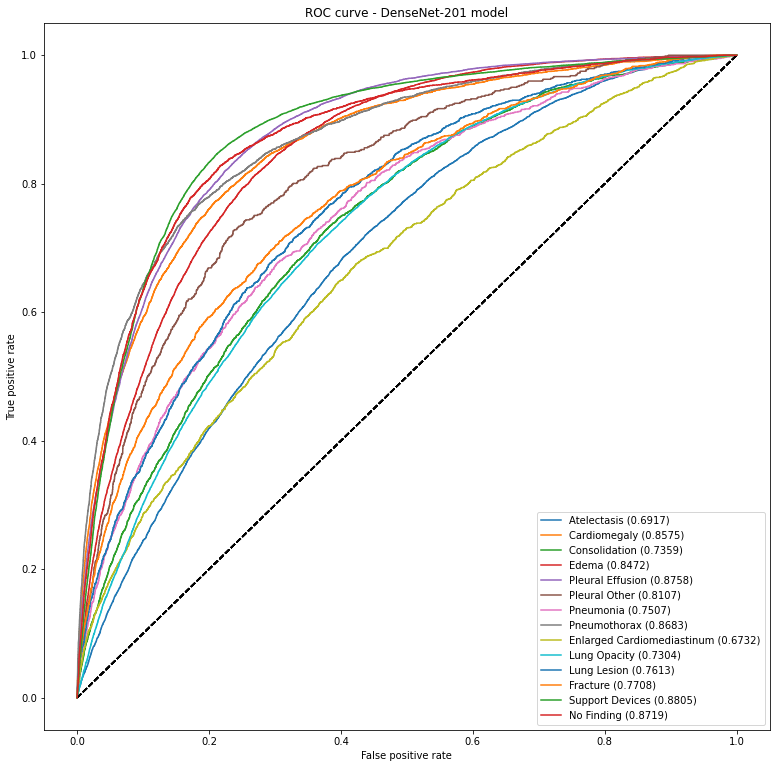

In [17]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_densenet201_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - DenseNet-201 model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [18]:
auc_roc_values

[0.6917187158062303,
 0.8574585390040904,
 0.7359088594426221,
 0.8471920493587455,
 0.8758093772359514,
 0.8106966474502298,
 0.7506944792274506,
 0.8683027060687074,
 0.6732119849777485,
 0.7303616432925715,
 0.7612693865753933,
 0.7708076355069591,
 0.8805304183969067,
 0.8719308643993896]

#### 2- Inception-ResNet-V2 model

##### 2.1 Classification Report

In [19]:
report_inceptionresnetv2_model = classification_report(
    y_true=test_datagenerator.labels,
    y_pred=predictions_inceptionresnetv2_model,
    digits=4,
    target_names=labels
)

print("Inception-ResNet-V2:\n")
print(report_inceptionresnetv2_model)

Inception-ResNet-V2:

                            precision    recall  f1-score   support

               Atelectasis     0.2525    0.5428    0.3446      6581
              Cardiomegaly     0.3344    0.7555    0.4636      5329
             Consolidation     0.1239    0.6599    0.2086      2958
                     Edema     0.5275    0.7350    0.6142     10259
          Pleural Effusion     0.7127    0.7974    0.7527     17259
             Pleural Other     0.0448    0.7175    0.0844       722
                 Pneumonia     0.0671    0.5659    0.1199      1221
              Pneumothorax     0.2726    0.8120    0.4082      3942
Enlarged Cardiomediastinum     0.0742    0.6274    0.1327      2147
              Lung Opacity     0.6211    0.7771    0.6904     21279
               Lung Lesion     0.0891    0.6647    0.1571      1843
                  Fracture     0.0998    0.5694    0.1698      1793
           Support Devices     0.8417    0.7912    0.8156     23259
                No Findin

/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 2.2 Confusion Matrix

In [20]:
confusion_matrix_inceptionresnetv2 = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels,
    y_pred=predictions_inceptionresnetv2_model
)

print("Inception-ResNet-V2:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_inceptionresnetv2[i, :, :])
    print("------------")

Inception-ResNet-V2:


Atelectasis:
[[27525 10577]
 [ 3009  3572]]
------------
Cardiomegaly:
[[31342  8012]
 [ 1303  4026]]
------------
Consolidation:
[[27921 13804]
 [ 1006  1952]]
------------
Edema:
[[27669  6755]
 [ 2719  7540]]
------------
Pleural Effusion:
[[21876  5548]
 [ 3496 13763]]
------------
Pleural Other:
[[32925 11036]
 [  204   518]]
------------
Pneumonia:
[[33850  9612]
 [  530   691]]
------------
Pneumothorax:
[[32200  8541]
 [  741  3201]]
------------
Enlarged Cardiomediastinum:
[[25732 16804]
 [  800  1347]]
------------
Lung Opacity:
[[13318 10086]
 [ 4744 16535]]
------------
Lung Lesion:
[[30309 12531]
 [  618  1225]]
------------
Fracture:
[[33681  9209]
 [  772  1021]]
------------
Support Devices:
[[17962  3462]
 [ 4857 18402]]
------------
No Finding:
[[31596  8500]
 [  804  3783]]
------------


##### 2.3 Receiver Operating Characteristic curve (ROC Curve)

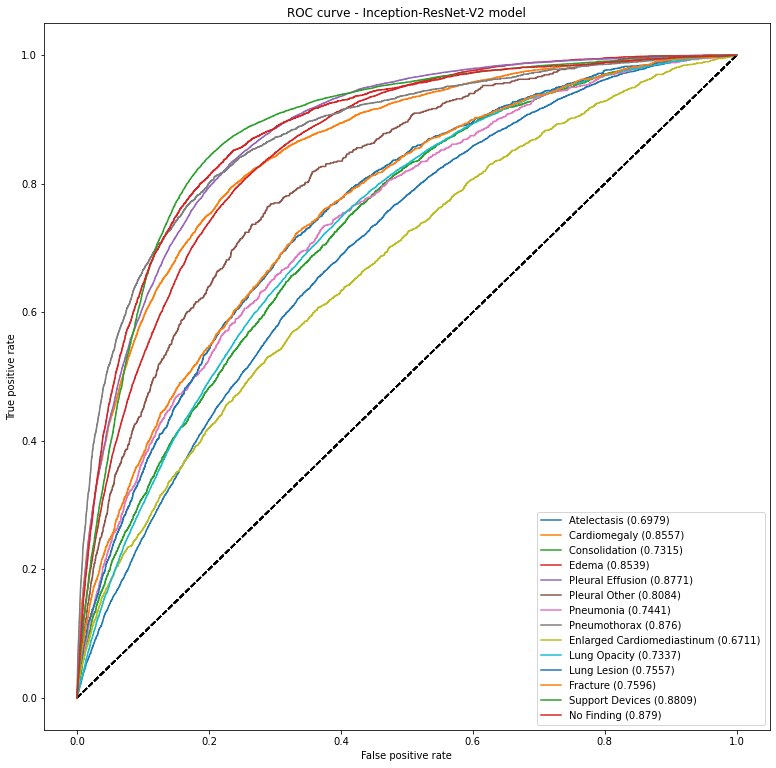

In [21]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_inceptionresnetv2_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - Inception-ResNet-V2 model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [22]:
auc_roc_values

[0.6978893521130284,
 0.8556952142460085,
 0.7315111460588037,
 0.8539180209904853,
 0.8770808746952446,
 0.8084370111231178,
 0.7441115684063546,
 0.8760419407542749,
 0.6711354075681881,
 0.7336817406049113,
 0.7556746500372621,
 0.7596435556684846,
 0.880909451490844,
 0.8789681959721347]

#### 3- Ensemble model

##### 3.1 Classification Report

In [23]:
report_ensemble_model = classification_report(
    y_true=test_datagenerator.labels,
    y_pred=predictions_ensemble_model,
    digits=4,
    target_names=labels
)

print(report_ensemble_model)

                            precision    recall  f1-score   support

               Atelectasis     0.2551    0.5388    0.3463      6581
              Cardiomegaly     0.3612    0.7579    0.4892      5329
             Consolidation     0.1322    0.6565    0.2200      2958
                     Edema     0.5265    0.7458    0.6173     10259
          Pleural Effusion     0.7117    0.8182    0.7612     17259
             Pleural Other     0.0464    0.7355    0.0872       722
                 Pneumonia     0.0721    0.5528    0.1276      1221
              Pneumothorax     0.3131    0.7872    0.4480      3942
Enlarged Cardiomediastinum     0.0812    0.6092    0.1432      2147
              Lung Opacity     0.6301    0.7576    0.6880     21279
               Lung Lesion     0.0951    0.6744    0.1667      1843
                  Fracture     0.1060    0.6386    0.1818      1793
           Support Devices     0.8293    0.8468    0.8379     23259
                No Finding     0.3211    0.8236

/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 3.2 Confusion Matrix

In [24]:
confusion_matrix_ensemble = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels,
    y_pred=predictions_ensemble_model
)

print("Ensemble:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_ensemble[i, :, :])
    print("------------")

Ensemble:


Atelectasis:
[[27749 10353]
 [ 3035  3546]]
------------
Cardiomegaly:
[[32210  7144]
 [ 1290  4039]]
------------
Consolidation:
[[28974 12751]
 [ 1016  1942]]
------------
Edema:
[[27544  6880]
 [ 2608  7651]]
------------
Pleural Effusion:
[[21702  5722]
 [ 3137 14122]]
------------
Pleural Other:
[[33042 10919]
 [  191   531]]
------------
Pneumonia:
[[34776  8686]
 [  546   675]]
------------
Pneumothorax:
[[33934  6807]
 [  839  3103]]
------------
Enlarged Cardiomediastinum:
[[27728 14808]
 [  839  1308]]
------------
Lung Opacity:
[[13941  9463]
 [ 5159 16120]]
------------
Lung Lesion:
[[31015 11825]
 [  600  1243]]
------------
Fracture:
[[33233  9657]
 [  648  1145]]
------------
Support Devices:
[[17369  4055]
 [ 3564 19695]]
------------
No Finding:
[[32109  7987]
 [  809  3778]]
------------


##### 3.3 Receiver Operating Characteristic curve (ROC Curve)

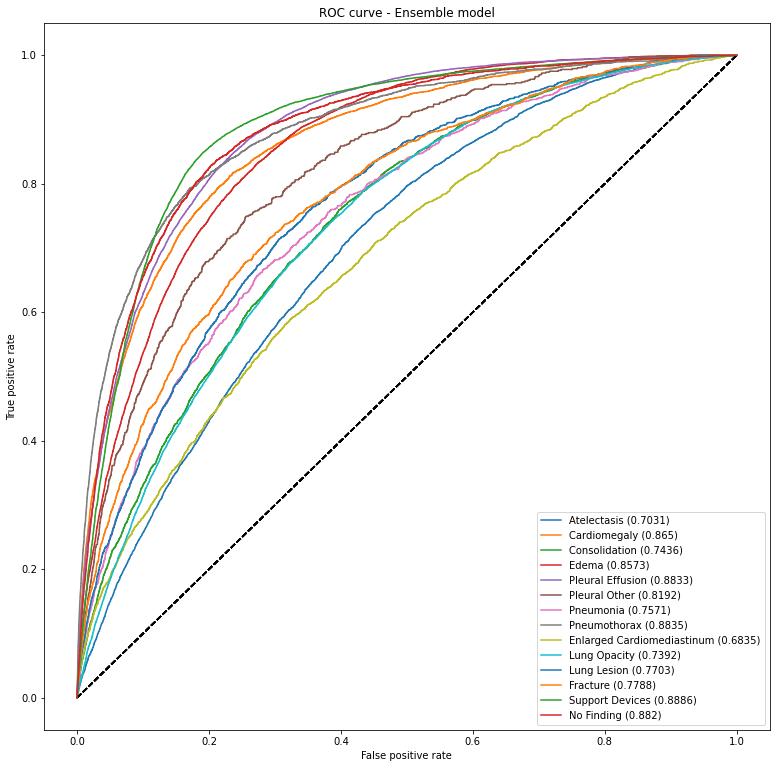

In [25]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_ensemble_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - Ensemble model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [26]:
auc_roc_values

[0.7031252099956329,
 0.8649860474663565,
 0.7436225389930771,
 0.8573038041089489,
 0.8832765824645764,
 0.8192255021307291,
 0.7570502342487065,
 0.8835158938154204,
 0.6834913951952938,
 0.7391659630515076,
 0.7702783147985184,
 0.7788296615279466,
 0.8885517448159266,
 0.8820122174407323]

### CheXpert competition labels (first 5 labels only)

In [27]:
# The dataset was modified as to make the first five labels the chexpert competition labels
labels = y_cols[:5]

In [28]:
labels

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

#### 1- DenseNet-201 model

##### 1.1 Classification Report

In [29]:
report_densenet201_model = classification_report(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_densenet201_model[:, :5],
    digits=4,
    target_names=labels
)

print(report_densenet201_model)

                  precision    recall  f1-score   support

     Atelectasis     0.2454    0.5353    0.3365      6581
    Cardiomegaly     0.3553    0.7394    0.4799      5329
   Consolidation     0.1326    0.6318    0.2192      2958
           Edema     0.5082    0.7428    0.6035     10259
Pleural Effusion     0.6977    0.8185    0.7533     17259

       micro avg     0.4156    0.7332    0.5305     42386
       macro avg     0.3878    0.6936    0.4785     42386
    weighted avg     0.4991    0.7332    0.5807     42386
     samples avg     0.3102    0.4482    0.3446     42386



/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 1.2 Confusion Matrix

In [30]:
confusion_matrix_densenet201 = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_densenet201_model[:, :5]
)

print("DenseNet-201\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_densenet201[i, :, :])
    print("------------")

DenseNet-201


Atelectasis:
[[27267 10835]
 [ 3058  3523]]
------------
Cardiomegaly:
[[32204  7150]
 [ 1389  3940]]
------------
Consolidation:
[[29500 12225]
 [ 1089  1869]]
------------
Edema:
[[27049  7375]
 [ 2639  7620]]
------------
Pleural Effusion:
[[21303  6121]
 [ 3133 14126]]
------------


##### 1.3 Receiver Operating Characteristic curve (ROC Curve)

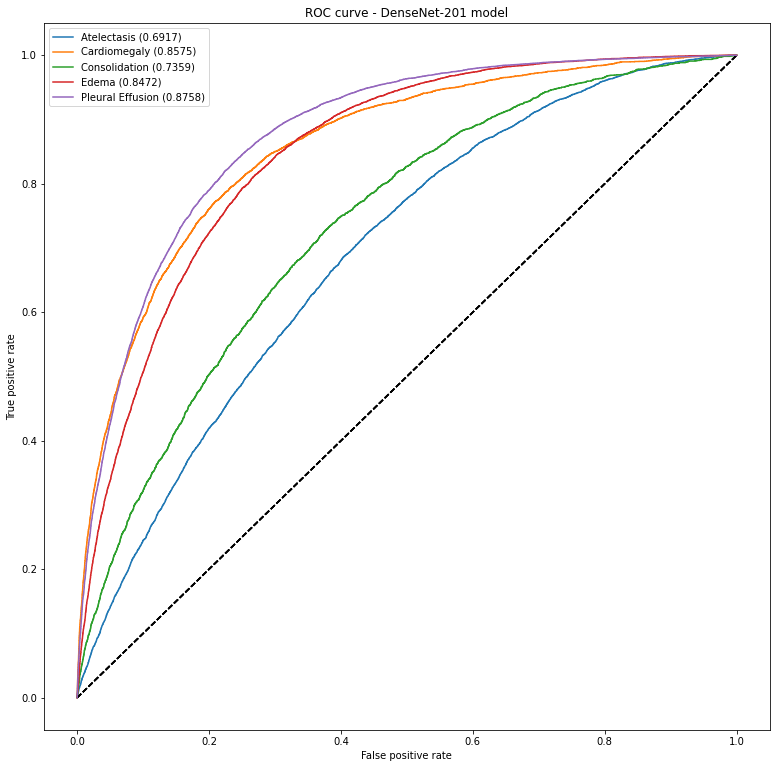

In [31]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_densenet201_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - DenseNet-201 model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [32]:
auc_roc_values

[0.6917187158062303,
 0.8574585390040904,
 0.7359088594426221,
 0.8471920493587455,
 0.8758093772359514]

#### 2- Inception-ResNet-V2 model

##### 2.1 Classification Report

In [33]:
report_inceptionresnetv2_model = classification_report(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_inceptionresnetv2_model[:, :5],
    digits=4,
    target_names=labels
)

print(report_ensemble_model)

                            precision    recall  f1-score   support

               Atelectasis     0.2551    0.5388    0.3463      6581
              Cardiomegaly     0.3612    0.7579    0.4892      5329
             Consolidation     0.1322    0.6565    0.2200      2958
                     Edema     0.5265    0.7458    0.6173     10259
          Pleural Effusion     0.7117    0.8182    0.7612     17259
             Pleural Other     0.0464    0.7355    0.0872       722
                 Pneumonia     0.0721    0.5528    0.1276      1221
              Pneumothorax     0.3131    0.7872    0.4480      3942
Enlarged Cardiomediastinum     0.0812    0.6092    0.1432      2147
              Lung Opacity     0.6301    0.7576    0.6880     21279
               Lung Lesion     0.0951    0.6744    0.1667      1843
                  Fracture     0.1060    0.6386    0.1818      1793
           Support Devices     0.8293    0.8468    0.8379     23259
                No Finding     0.3211    0.8236

/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 2.2 Confusion Matrix

In [34]:
confusion_matrix_inceptionresnetv2 = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_inceptionresnetv2_model[:, :5]
)

print("Inception-ResNet-V2:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_inceptionresnetv2[i, :, :])
    print("------------")

Inception-ResNet-V2:


Atelectasis:
[[27525 10577]
 [ 3009  3572]]
------------
Cardiomegaly:
[[31342  8012]
 [ 1303  4026]]
------------
Consolidation:
[[27921 13804]
 [ 1006  1952]]
------------
Edema:
[[27669  6755]
 [ 2719  7540]]
------------
Pleural Effusion:
[[21876  5548]
 [ 3496 13763]]
------------


##### 2.3 Receiver Operating Characteristic curve (ROC Curve)

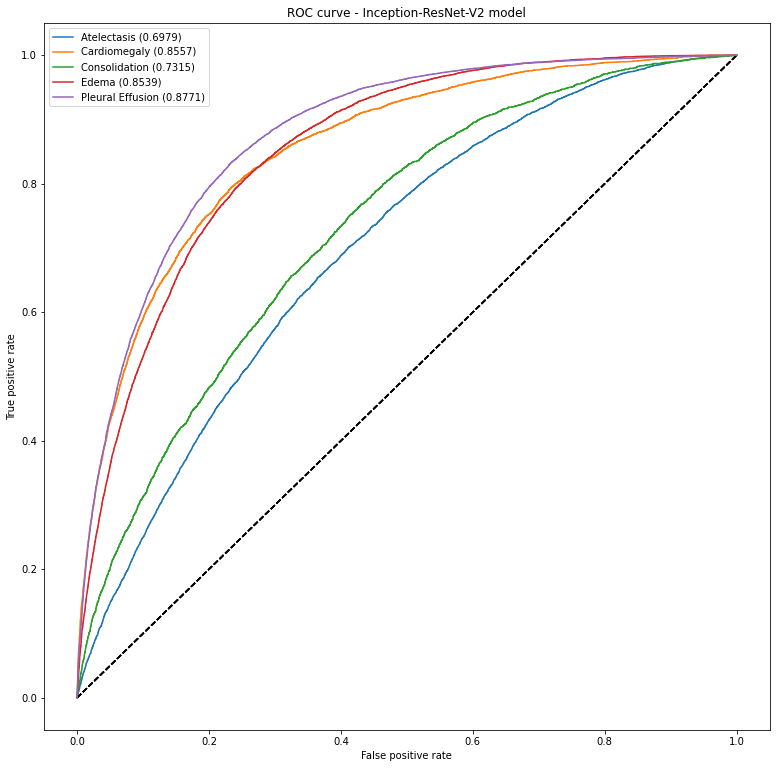

In [35]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_inceptionresnetv2_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - Inception-ResNet-V2 model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [36]:
auc_roc_values

[0.6978893521130284,
 0.8556952142460085,
 0.7315111460588037,
 0.8539180209904853,
 0.8770808746952446]

#### 3- Ensemble model

##### 3.1 Classification Report

In [37]:
report_ensemble_model = classification_report(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_ensemble_model[:, :5],
    digits=4,
    target_names=labels
)

print(report_ensemble_model)

                  precision    recall  f1-score   support

     Atelectasis     0.2551    0.5388    0.3463      6581
    Cardiomegaly     0.3612    0.7579    0.4892      5329
   Consolidation     0.1322    0.6565    0.2200      2958
           Edema     0.5265    0.7458    0.6173     10259
Pleural Effusion     0.7117    0.8182    0.7612     17259

       micro avg     0.4221    0.7385    0.5372     42386
       macro avg     0.3973    0.7035    0.4868     42386
    weighted avg     0.5115    0.7385    0.5900     42386
     samples avg     0.3099    0.4503    0.3451     42386



/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 3.2 Confusion Matrix

In [38]:
confusion_matrix_ensemble = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_ensemble_model[:, :5]
)


print("Ensemble:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_ensemble[i, :, :])
    print("------------")

Ensemble:


Atelectasis:
[[27749 10353]
 [ 3035  3546]]
------------
Cardiomegaly:
[[32210  7144]
 [ 1290  4039]]
------------
Consolidation:
[[28974 12751]
 [ 1016  1942]]
------------
Edema:
[[27544  6880]
 [ 2608  7651]]
------------
Pleural Effusion:
[[21702  5722]
 [ 3137 14122]]
------------


##### 3.3 Receiver Operating Characteristic curve (ROC Curve)

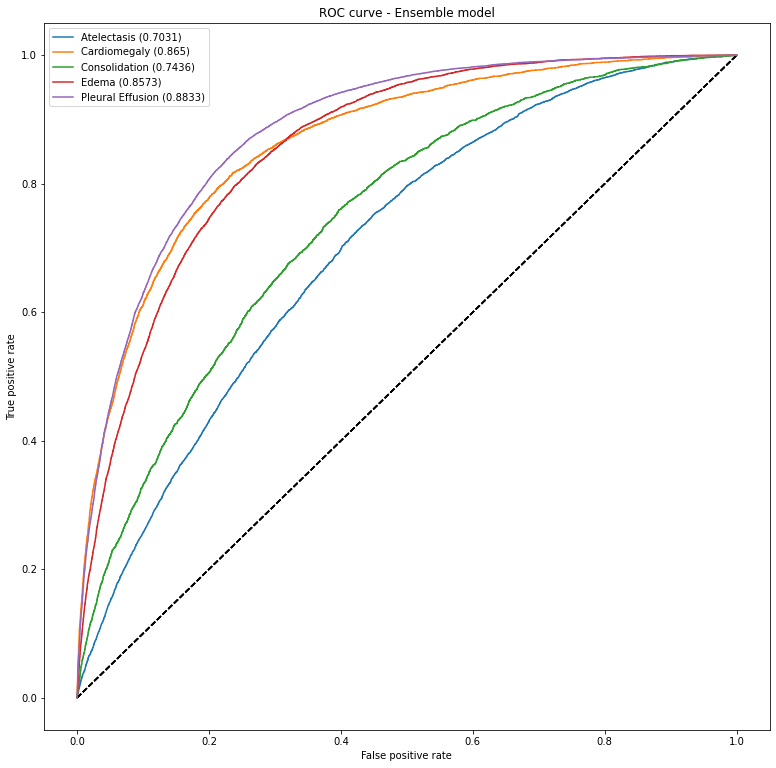

In [39]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_ensemble_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - Ensemble model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [40]:
auc_roc_values

[0.7031252099956329,
 0.8649860474663565,
 0.7436225389930771,
 0.8573038041089489,
 0.8832765824645764]